In [1]:
!pip install wordcloud
!pip install gensim
!pip install -U sentence-transformers

# Etapa 1: Modelagem de Sentenças

In [2]:
# MODEL = 'bert-base-cased'
MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# MODEL = 'fagner/envoy'
# MODEL = 'iln-biobert'
# MODEL = 'sts-bert'

In [3]:
import os.path
import pandas as pd
from sentence_transformers import SentenceTransformer

DATASET = 'clicr'

# DATASET_PATH = '../datasets/'+DATASET+'/clinicalcases.tsv'
DATASET_PATH = '../datasets/'+DATASET+'/titles-sem-mark.txt'
# DATASET_PATH = '../datasets/'+DATASET+'/titles-com-mark.txt'

sentences = []
with open(DATASET_PATH) as f:
    sentences = f.readlines()

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += 'MNT/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
MODEL_PATH = '../../models/' + MODEL

model = SentenceTransformer(MODEL)
# model = SentenceTransformer(MODEL_PATH)

embeddings = model.encode(sentences)

No sentence-transformers model found with name /home/jovyan/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.1. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/jovyan/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly 

In [5]:
# TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_2/' + DATASET + '/' + MODEL + '/'

# embeddings_dataframe = pd.read_csv(TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
# embeddings_numpy = embeddings_dataframe.to_numpy()

# embeddings = embeddings_numpy[:, :-1]

In [6]:
# sentences_dataframe = pd.read_csv(FILE, sep='\t',header=None)
# sentences = sentences_dataframe.to_numpy()

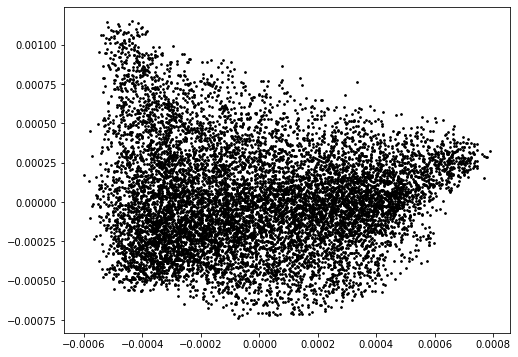

In [7]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='black', s=3)

# plt.scatter(x, y, color='white', s=1)
# for i, sentence in enumerate(sentences):
#     plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=15)

plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(MODEL).replace('/','').replace('.',''))

In [8]:
plt.show()

# Etapa 2: Agrupamento de Sentenças

In [9]:
# DISTANCE_THRESHOLD =  37.5# 130  78 65 49 44 38 37.5  bert-base-cased (com mark)
# DISTANCE_THRESHOLD =  48 # 100  80 62 55 48 bert-base-cased (sem mark)

# DISTANCE_THRESHOLD  = 63 # 170 130 63 58.9 50 48 biobert 
DISTANCE_THRESHOLD  =  52 # 90  biobert (sem mark)

# DISTANCE_THRESHOLD =   350 # 350 220 200 120 90 85envoy(title-com-mark)
# DISTANCE_THRESHOLD =   160 # 460 300 220 180 130envoy

# DISTANCE_THRESHOLD =   85 # 200 150 130 90 85 80 iln-biobert (title-com-mark)
# DISTANCE_THRESHOLD =   125 # 300 iln-biobert

# DISTANCE_THRESHOLD =    88 #  175 140 130 90 89 sts-bert(title-com-mark)
# DISTANCE_THRESHOLD =   175  #   150 130 120 96 95.6 sts-bert


In [10]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)

colors = [plt.cm.nipy_spectral(label / 10.) for label in clustering_model.labels_]
n_clusters = clustering_model.n_clusters_

print('Limiar de distância: ', DISTANCE_THRESHOLD)
print('Agrupamentos resultantes',  n_clusters)

Limiar de distância:  52
Agrupamentos resultantes 7


<Figure size 432x288 with 0 Axes>

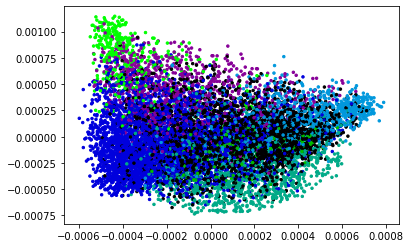

In [11]:
plt.clf()

plt.figure(figsize=(6, 4))

# for i, txt in enumerate(provas):
#     plt.annotate(txt, (x[i], y[i]), fontsize=15)
    
plt.scatter(x, y, color=colors, s=6, cmap='hsv_r')

if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-axis-on-'+str(MODEL).replace('/','').replace('.',''))




<Figure size 432x288 with 0 Axes>

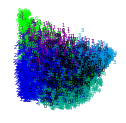

In [12]:
plt.clf()
plt.figure(figsize=(2, 2))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(sentences):
    # plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color='gray', fontsize=18)
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=5)

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-axis-off-'+str(MODEL).replace('/','').replace('.',''))

<Figure size 432x288 with 0 Axes>

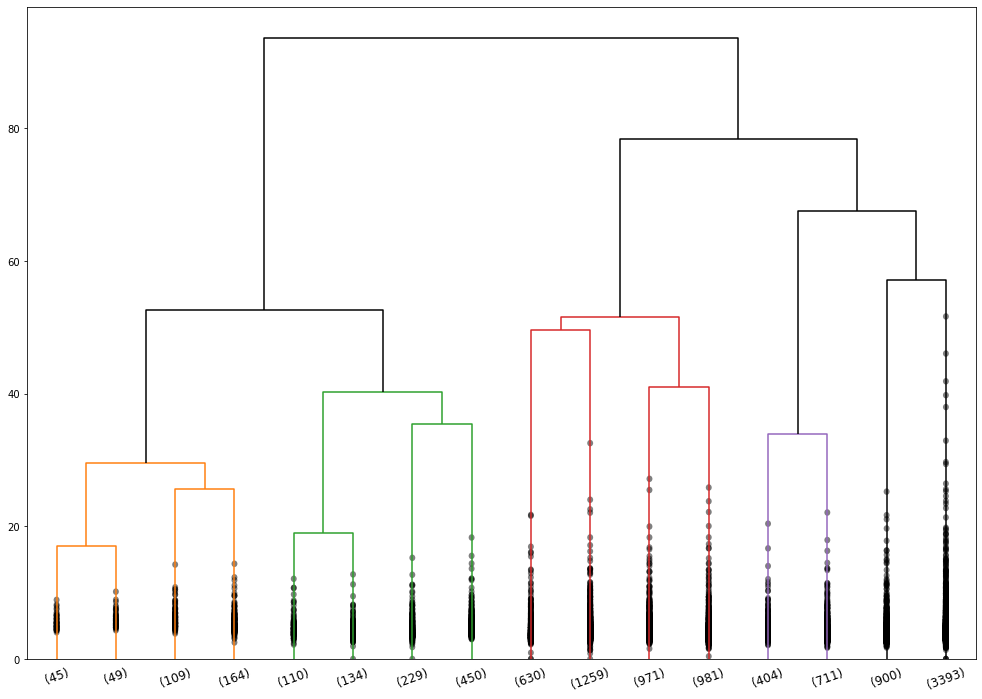

In [13]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(17,12))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    # print(merge[0])
    current_count = 0
    for child_idx in merge:
        # print(child_idx)
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

# r = dendrogram(linkage_matrix,  count_sort='ascending')
r = dendrogram(linkage_matrix, truncate_mode='level', p=3, color_threshold=DISTANCE_THRESHOLD, count_sort='ascending', leaf_rotation=20, above_threshold_color='black', show_contracted=True)

plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.',''))

In [14]:
plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(MODEL).replace('/','').replace('.',''))

<Figure size 432x288 with 0 Axes>

# Etapa 3: Extração de Tópicos

In [15]:
MIN_DF = 1
MAX_DF = 0.99

In [16]:
class Topic:
    # label = int()
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.wordcloud = WordCloud()
        self.top_terms = []
        self.top_tfidfs = []
        self.coherence = 0.0
        
        
    # def __str__(self):
    #     return str(self.label)


In [17]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


# topics = [''] * n_clusters
# topics2 = [Topic()] * n_clusters
# topics2 = [Topic(i) for i in range(n_clusters)]
topics = [Topic(i) for i in range(n_clusters)]

documents_by_topic = [[] for i in range(n_clusters)]
# documents_by_topic = [[]] * n_clusters

# print(documents_by_topic)

# n_cases_by_cluster = [[] for i in range(n_clusters)]
# 
n_cases_by_cluster = [0 for i in range(n_clusters)]

# topic = Topic()

for i in range(len(sentences)):
    cluster_index = clustering_model.labels_[i]
    # documents_by_topic[cluster_index].append(sentences[i])
    topics[cluster_index].sentences.append(sentences[i])

    topics[cluster_index].sentences_dump += sentences[i] + " "
    # topics[cluster_index] += sentences[i] + " "

    # n_cases_by_cluster[i] += 1

    # for i in clustering_model.labels_:
    n_cases_by_cluster[cluster_index] += 1
    # print(n_cases_by_cluster)
    
    # if i<10:
    #     print(documents_by_topic[cluster_index])
    #     print()

    # topics2[cluster_index].cluster = cluster_index
    # topics2[cluster_index].sentences.append(sentences[i])
    # topics2[cluster_index].cluster = cluster_index
    # topics2[cluster_index].sentences.append(sentences[i])
    
    
tfidf_model = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
# tfidf_model = TfidfVectorizer(stop_words='english')

# document_term_matrix = tfidf_model.fit_transform(topics)
document_term_matrix = tfidf_model.fit_transform([topic.sentences_dump for topic in topics])

terms = tfidf_model.get_feature_names_out()
terms_by_topic = tfidf_model.inverse_transform(document_term_matrix)
tfidf_matrix = document_term_matrix.toarray()

top_terms_by_topic = []
top_tfidfs_by_topic = []
wordclouds = []

for topic in topics:
# for topic in range(len(topics)):
    sorted_tfidf = np.argsort(tfidf_matrix[topic.cluster])

    top_tfidf_indexes = sorted_tfidf[:]

    top_terms,top_tfidfs = [],[]
    for i in sorted_tfidf:
        top_terms.append(terms[i])
        top_tfidfs.append(tfidf_matrix[topic.cluster][i])
        # top_tfidfs.append(tfidf_matrix[topic][i])

       
    topic.top_terms = top_terms
    topic.top_tfidfs.append(top_tfidfs)
    
    # top_terms_by_topic.append(top_terms)
    # top_tfidfs_by_topic.append(top_tfidfs)
    
    dense = document_term_matrix[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)

    wordcloud = WordCloud(mode='RGBA', background_color='white', max_words=20, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))
    wordclouds.append(wordcloud)
    topic.wordcloud = wordcloud

In [18]:
# plt.figure(figsize=(5, 4))

# for i, wc in enumerate(wordclouds):
#     plt.clf()

#     # print(top_terms_by_topic[i][-10:])
#     plt.imshow(wc)
#     plt.axis("off")
#     plt.savefig(OUTPUT_PATH + 'wordcloud'+str(i))
#     plt.show()

In [19]:
# for i, sentence in enumerate(sentences):
#     cluster_index = clustering_model.labels_[i]
#     documents_by_topic[cluster_index].append(sentences[i])
    
#     # for i, sentence in enumerate(sentences):
#     # plt.annotate(sentence, (x[i], y[i]), fontsize=15)

In [20]:
# fig, axes = plt.subplots(1, len(top_terms_by_topic), figsize=(30, 15), sharex=True)
plt.clf()
# axes = axes.flatten()

# print(top_terms_by_topic[0][-1])
for i in range(len(top_terms_by_topic)):
    # ax = axes[i]
    # print(top_terms_by_topic[i])
    fig, ax = plt.subplots(figsize=(3, 9))
    # plt.figure(figsize=(6, 4))


    for j in range(len(top_tfidfs_by_topic[i])):
        if top_tfidfs_by_topic[i][j] > 0:
            # index_of_non_zero = j
            break
        
    
    print(j)
    
    print(top_terms_by_topic[i][j], top_tfidfs_by_topic[i][j])

#     highlighted_labels = ['']*len(top_terms_by_topic[i])
#     for k in range(len(top_terms_by_topic[i])):
#         if k in [j, len(top_tfidfs_by_topic[i])-1]:
#             highlighted_labels[k] = top_terms_by_topic[i][k]

#             # print(highlighted_labels[0])
#     # print(highlighted_labels[j])

#     # ax.barh(highlighted_labels, top_tfidfs_by_topic[i], height=1)

    ax.barh(top_terms_by_topic[i][j:], top_tfidfs_by_topic[i][j:], align='edge', linewidth=1)
    # ax.set_title(f"topic-distribution{i +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.set_ylabel('Termos')
    ax.set_xlabel('TF-IDF')

    # ax.tick_params(axis="both", which="major")
    # tick_label
                   # , labelsize=1)
    # for j in "top right left".split():
    #     ax.spines[j].set_visible(True)
    # fig.suptitle('Tópicos', fontsize=30)
    
    plt.savefig(OUTPUT_PATH + '(copy)topic-distribution'+str(i+1))
    plt.show()

<Figure size 432x288 with 0 Axes>

# Validação

In [21]:
TOP_WORDS = 20

In [22]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus]

cm = CoherenceModel(topics=[topic.top_terms for topic in topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)
# cm = CoherenceModel(topics=top_terms_by_topic, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

total_coherence = cm.get_coherence()

coherence_per_topic = cm.get_coherence_per_topic()
for i, coherence in enumerate(coherence_per_topic):
    topics[i].coherence = coherence

print('Total coherence: ', total_coherence)
print('Coerencia by Topic: ', coherence_per_topic)    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

<Figure size 432x288 with 0 Axes>

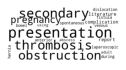

<Figure size 432x288 with 0 Axes>

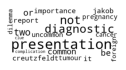

<Figure size 432x288 with 0 Axes>

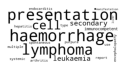

<Figure size 432x288 with 0 Axes>

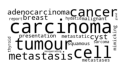

<Figure size 432x288 with 0 Axes>

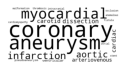

<Figure size 432x288 with 0 Axes>

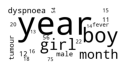

<Figure size 432x288 with 0 Axes>

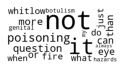

In [23]:
# wordcloud_by_topic = sorted(zip(coherence_per_topic, wordclouds))


for topic in topics:
    plt.clf()
    # plt.figure(figsize=(5, 4))
    plt.figure(figsize=(2, 2))

    # print(top_terms_by_topic[i][-10:])
    plt.imshow(topic.wordcloud)
    plt.axis("off")
    # plt.savefig(OUTPUT_PATH + str(len(topics)) + 'topics/clusters-with-axis-'+str(MODEL).replace('/','').replace('.',''))
    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster))
    # plt.savefig(OUTPUT_PATH + 'wordcloud'+str(i))

    plt.show()

In [24]:
with open(OUTPUT_PATH + '/mntresults.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Modelo de linguagem: ' + MODEL + '\t Limiar de distância: '+str(DISTANCE_THRESHOLD) + '\t Qtdd de Tópicos: '+str(n_clusters) + '\t Limiar TF-IDF: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    # print('Qtdd de Tópicos: '+str(n_clusters), file=file)   
    # print('Limiar TF-IDF: '+str(MAX_DF), file=file)  
    # print('Coerência por Tópicos: '+str(coherence_per_topic), file=file)  
    # print('Top Words: '+str(TOP_WORDS), file=file)  
    
    # coherence_and_top_termns_by_topic = sorted(zip(coherence_per_topic, top_terms_by_topic))
    print("", file=file)
    # for i in range(len(top_terms_by_topic)):
    for topic in topics:

        print('Tópico '+str(topic.cluster), file=file)    

        #     print('Coerência: '+str(coherence_and_top_termns_by_topic[i][0]), file=file)
        print('Coerência: '+str(topic.coherence), file=file)
        
        print('Melhores termos: '+str(topic.top_terms[-10:]), file=file)    
        # print('Melhores termos: '+str(coherence_and_top_termns_by_topic[i][1][-10:]), file=file)      

    #     print('Qtdd casos: '+str(len(documents_by_topic[i])), file=file)
        print('Qtdd casos: '+str(len(topic.sentences)), file=file)

        
        labels_ = clustering_model.labels_.tolist()
        # print(labels_.count(0))
        
        
        
        print('', file=file)

    print('Coerência total: '+str(total_coherence), file=file)  
    print('----------------------------------------------------------------------------', file=file)  


In [25]:
print(clustering_model.labels_[:10])
print('cluster: '+str(clustering_model.labels_[1]))
sentences[1]

[2 4 0 2 6 0 0 3 2 4]
cluster: 4


'Ruptured pseudoaneurysm of the radial artery\n'

In [26]:
print(clustering_model.labels_[:10])
print('cluster: '+str(clustering_model.labels_[1]))
sentences[1]

[2 4 0 2 6 0 0 3 2 4]
cluster: 4


'Ruptured pseudoaneurysm of the radial artery\n'

In [27]:
# topics[0]

In [28]:
# coherence_and_top_termns_by_topic = sorted(zip(coherence_per_topic, top_terms_by_topic))

# # # for i in range(len(top_terms_by_topic)):
# for i in range(len(top_terms_by_topic)):

#     # for j in range(len(top_tfidfs_by_topic[i])):
#     #     if top_tfidfs_by_topic[i][j] > 0:
#     #         # index_of_non_zero = j
#     #         break
    
#     print('Tópico '+str(i))    
#     print('Coerência: '+str(coherence_and_top_termns_by_topic[i][0]))
    
#     print('10 melhores termos: '+str(coherence_and_top_termns_by_topic[i][1][-10:]))
    
#     with open(OUTPUT_PATH + '/mntresults.txt', "a") as file:
#         print('Tópico '+str(i))    
#         print('Coerência: '+str(coherence_and_top_termns_by_topic[i][0]))
#         print('10 melhores termos: '+str(coherence_and_top_termns_by_topic[i][1][-10:]))

#     # print('Dez piores: '+str(syx[i][1][:10]))
# #     print()

# #     valor = len(top_terms_by_topic)-1 - i
# #     print('Tópico '+str(valor))
# #     print('Coerência: '+str(syx[valor][0]))
# #     print('Dez melhores: '+str(syx[valor][1][-10:]))

---------------------------------------------

TopicAttention

In [29]:
val = np.inner(embeddings[0],embeddings[1])


In [30]:
# MODEL = 'biobert-base'
# MODEL = 'bert-base-cased'
WORD_MODEL = 'ACD'

WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/'

word_embeddings_dataframe = pd.read_csv(WORD_EMBEDDINGS_TSV_INPUT_PATH + 'word_embeddings.tsv', sep='\t',header=None)
word_embeddings_numpy = word_embeddings_dataframe.to_numpy()

word_embeddings = word_embeddings_numpy[:, :-1]

In [31]:
WORD_EMBEDDINGS_TSV_INPUT_PATH = '../from_embeddings_to_tsv/output_from_1/' + WORD_MODEL + '/labels.tsv'


terms = []
with open(WORD_EMBEDDINGS_TSV_INPUT_PATH) as f:
    terms = f.readlines()

In [32]:
val = np.inner(embeddings[0],word_embeddings[1])
val

-0.49216898951136623

In [33]:
# terms[-100:]
# terms[:1000]

In [34]:
from numpy import argsort
# min = 0
dists = [''] * len(word_embeddings)
dist_indexes = [''] * len(dists)

print(len(dists))
print(len(terms))
for i, embedding in enumerate(word_embeddings):
    dist = np.inner(embeddings[1],embedding)
    dists[i] = dist
    
    # dist_indexes
    # = i
    # if dist < min:
    #     min = dist

sorted_dists = sorted(dists)
# print(dists)

args = argsort(dists)
# print()
# print(sorted_dists)
# print(terms[args[3]])
i = 0

# print(args)
# for a in args:
#     if not terms[a].startswith('##'):
#         print(terms[a])
#     # print(terms[a])

#     i = i+1
#     if i>10000:
#         break;
        
with open(OUTPUT_PATH + '/mainterms.txt', "a") as file:
    print('Word: '+WORD_MODEL, file=file)  
    print('Sentence: ' + sentences[1], file=file)
    for a in args:
        if not terms[a].startswith('##'):
            print(terms[a], file=file)   
            i = i+1
            if i>100:
                break;
            
        # print(terms[a])

        # i = i+1
        # if i>10000:
        #     break;
    print('----------------------------------------------------------------------------', file=file)  

28996
28996


In [35]:
sorted_dists[:10]

[-2.1861470367196043,
 -1.9695483521377648,
 -1.9658907445245206,
 -1.955209324903132,
 -1.8328152010239096,
 -1.8117771939843914,
 -1.8093614956184716,
 -1.7948219169779303,
 -1.792994521413031,
 -1.7766594508122302]

In [36]:
terms[17730]

'SH\n'